In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Step 1: Create the synthetic dataset
np.random.seed(42)

def create_synthetic_data():
    years = [2023, 2024, 2025]
    months = ['January', 'February', 'March', 'April', 'May', 'June',
              'July', 'August', 'September', 'October', 'November', 'December']
    month_nums = list(range(1, 13))

    data = []
    for year in years:
        for month_name, month_num in zip(months, month_nums):
            # Generate base values with some seasonality
            seasonal_factor = 1 + 0.3 * np.sin(2 * np.pi * (month_num - 1) / 12)
            trend = 1 + 0.1 * ((year - 2023) + (month_num - 1)/12)

            base_value = 100 * trend * seasonal_factor

            # Generate features with correlations
            committed = np.random.normal(base_value * 0.8, base_value * 0.2)
            uncommitted = np.random.normal(base_value * 0.5, base_value * 0.15)
            pipeline = np.random.normal(base_value * 1.5, base_value * 0.3)

            # Create actual revenue with some noise (target variable)
            actual_revenue = (0.4 * committed + 0.3 * uncommitted + 0.2 * pipeline +
                            np.random.normal(0, base_value * 0.1))

            data.append({
                'year': year,
                'month_name': month_name,
                'month_num': month_num,
                'committed': max(0, committed),
                'uncommitted': max(0, uncommitted),
                'pipeline': max(0, pipeline),
                'actual_revenue': max(0, actual_revenue)
            })

    return pd.DataFrame(data)

# Create the dataset
df = create_synthetic_data()
print("Step 1: Dataset created")
print(f"Shape: {df.shape}")
print(f"Years: {df['year'].unique()}")
print("\nFirst few rows:")
print(df.head())
print("\n" + "="*80)

# Step 2: Prepare train and test data
train_data = df[df['year'].isin([2023, 2024])].copy()
# Simulating being in May 2025
current_month = 5  # May
test_data_available = df[(df['year'] == 2025) & (df['month_num'] <= current_month)].copy()
test_data_future = df[(df['year'] == 2025) & (df['month_num'] > current_month)].copy()

# Features and target
feature_cols = ['committed', 'uncommitted', 'pipeline']
target_col = 'actual_revenue'

X_train = train_data[feature_cols]
y_train = train_data[target_col]

print("Step 2: Data prepared for training")
print(f"Train data shape: {X_train.shape}")
print(f"Test data available (2025 Jan-May): {test_data_available.shape}")
print(f"Test data future (2025 Jun-Dec): {test_data_future.shape}")
print("\n" + "="*80)

# Step 3: Create the simulation function using emw_6 logic
def simulate_test_data(train_df, available_test_df, months_to_simulate, feature_columns):
    """
    Simulate future test data using EWMA (Exponential Weighted Moving Average) with window 6

    Parameters:
    -----------
    train_df: Training dataframe
    available_test_df: Test data available up to current month
    months_to_simulate: Number of months to simulate
    feature_columns: List of feature columns to simulate

    Returns:
    --------
    DataFrame with simulated features for future months
    """
    # Combine train and available test data for pattern recognition
    combined_data = pd.concat([train_df, available_test_df])
    combined_data = combined_data.sort_values(['year', 'month_num']).reset_index(drop=True)

    simulated_data = []

    for i in range(months_to_simulate):
        # Calculate the month number and year for simulation
        last_month = combined_data.iloc[-1]
        new_month_num = last_month['month_num'] + 1
        new_year = last_month['year']

        if new_month_num > 12:
            new_month_num = 1
            new_year += 1

        month_names = ['January', 'February', 'March', 'April', 'May', 'June',
                      'July', 'August', 'September', 'October', 'November', 'December']

        new_row = {
            'year': new_year,
            'month_name': month_names[new_month_num - 1],
            'month_num': new_month_num
        }

        # For each feature, calculate EWMA with window 6
        for feature in feature_columns:
            # Get the last 6 values of the feature
            feature_values = combined_data[feature].tail(6).values

            if len(feature_values) < 6:
                # If not enough data, use average of available values
                ewma_value = np.mean(feature_values)
            else:
                # Calculate EWMA with alpha = 2/(window+1)
                alpha = 2 / (6 + 1)
                weights = [(1 - alpha) ** (6 - j - 1) for j in range(6)]
                weights = np.array(weights) / np.sum(weights)
                ewma_value = np.sum(feature_values * weights)

            # Add some randomness to avoid perfect patterns
            randomness = np.random.normal(0, ewma_value * 0.05)
            new_row[feature] = max(0, ewma_value + randomness)

        # Create a new dataframe row
        new_df_row = pd.DataFrame([new_row])
        combined_data = pd.concat([combined_data, new_df_row], ignore_index=True)
        simulated_data.append(new_row)

    return pd.DataFrame(simulated_data)

# Step 4: Simulate the future months data
months_to_simulate = 12 - current_month  # June to December
simulated_features = simulate_test_data(
    train_df=train_data,
    available_test_df=test_data_available,
    months_to_simulate=months_to_simulate,
    feature_columns=feature_cols
)

print("Step 3 & 4: Simulated future months data")
print(f"Simulated {months_to_simulate} months (June to December 2025)")
print("\nSimulated data:")
print(simulated_features)
print("\n" + "="*80)

# Step 5: Train Elastic Net model
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X_train, y_train)

print("Step 5: Model trained")
print(f"Model coefficients: {elastic_net.coef_}")
print(f"Model intercept: {elastic_net.intercept_:.2f}")
print("\n" + "="*80)

# Step 6: Make predictions on simulated data
X_simulated = simulated_features[feature_cols]
y_pred_simulated = elastic_net.predict(X_simulated)

# Add predictions to simulated data
simulated_data_full = simulated_features.copy()
simulated_data_full['predicted_revenue'] = y_pred_simulated

# Step 7: Compare with actual test data
# Get actual values for the same months
actual_future_data = test_data_future[['year', 'month_name', 'month_num', 'actual_revenue']].copy()

# Merge predicted and actual
comparison_df = pd.merge(
    simulated_data_full,
    actual_future_data,
    on=['year', 'month_name', 'month_num'],
    how='left'
)

print("Step 7: Comparison of predicted vs actual")
print("\nMonth-wise comparison:")
for _, row in comparison_df.iterrows():
    print(f"{row['month_name']} {row['year']}: "
          f"Predicted=${row['predicted_revenue']:,.0f}, "
          f"Actual=${row['actual_revenue']:,.0f}, "
          f"Diff=${(row['predicted_revenue'] - row['actual_revenue']):,.0f} "
          f"({((row['predicted_revenue'] - row['actual_revenue'])/row['actual_revenue']*100):+.1f}%)")

print("\n" + "="*80)

# Step 8: Calculate metrics
def calculate_metrics(y_true, y_pred):
    """Calculate various evaluation metrics"""
    # Filter out any NaN values
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    metrics = {
        'MAPE': mean_absolute_percentage_error(y_true, y_pred) * 100,
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'MAE': np.mean(np.abs(y_true - y_pred))
    }
    return metrics

# Calculate metrics
metrics = calculate_metrics(
    comparison_df['actual_revenue'].values,
    comparison_df['predicted_revenue'].values
)

# Step 9: Create metrics table
metrics_table = pd.DataFrame({
    'Metric': ['MAPE (%)', 'RMSE', 'R² Score', 'MAE'],
    'Value': [
        f"{metrics['MAPE']:.2f}%",
        f"{metrics['RMSE']:,.2f}",
        f"{metrics['R2']:.4f}",
        f"{metrics['MAE']:,.2f}"
    ],
    'Interpretation': [
        'Lower is better (Mean Absolute Percentage Error)',
        'Lower is better (Root Mean Square Error)',
        'Higher is better (Closer to 1)',
        'Lower is better (Mean Absolute Error)'
    ]
})

print("Step 8 & 9: Model Performance Metrics")
print("\n" + "="*50)
print("PERFORMANCE METRICS TABLE")
print("="*50)
print(metrics_table.to_string(index=False))
print("="*50)

# Additional Analysis
print("\nADDITIONAL ANALYSIS")
print("="*50)

# Overall accuracy
accuracy = 100 - metrics['MAPE']
print(f"Overall Predictive Accuracy: {accuracy:.1f}%")

# Monthly performance breakdown
print("\nMonthly Performance Breakdown:")
print("-" * 60)
monthly_errors = []
for _, row in comparison_df.iterrows():
    if not pd.isna(row['actual_revenue']):
        error_pct = abs((row['predicted_revenue'] - row['actual_revenue']) / row['actual_revenue'] * 100)
        monthly_errors.append(error_pct)
        print(f"{row['month_name']}: {error_pct:.1f}% error")

print(f"\nBest month: {comparison_df['month_name'][np.argmin(monthly_errors)]} "
      f"({min(monthly_errors):.1f}% error)")
print(f"Worst month: {comparison_df['month_name'][np.argmax(monthly_errors)]} "
      f"({max(monthly_errors):.1f}% error)")
print(f"Average monthly error: {np.mean(monthly_errors):.1f}%")

# Feature importance analysis
print("\nFeature Importance Analysis:")
print("-" * 40)
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': elastic_net.coef_,
    'Absolute_Importance': np.abs(elastic_net.coef_)
}).sort_values('Absolute_Importance', ascending=False)

print(feature_importance.to_string(index=False))

# # Save results to CSV
# comparison_df.to_csv('elastic_net_predictions_comparison.csv', index=False)
# metrics_table.to_csv('model_performance_metrics.csv', index=False)

# print("\n" + "="*80)
# print("Results saved to CSV files:")
# print("1. elastic_net_predictions_comparison.csv")
# print("2. model_performance_metrics.csv")
# print("="*80)

Step 1: Dataset created
Shape: (36, 7)
Years: [2023 2024 2025]

First few rows:
   year month_name  month_num   committed  uncommitted    pipeline  \
0  2023    January          1   89.934283    47.926035  169.430656   
1  2023   February          2   87.336260    53.906647  228.874366   
2  2023      March          3   90.438256    74.463920  174.314239   
3  2023      April          4  113.048295    28.383311  130.921410   
4  2023        May          5   77.774001    71.226374  159.808176   

   actual_revenue  
0       99.467954  
1      105.780416  
2       87.412239  
3       72.426112  
4       66.053761  

Step 2: Data prepared for training
Train data shape: (24, 3)
Test data available (2025 Jan-May): (5, 7)
Test data future (2025 Jun-Dec): (7, 7)

Step 3 & 4: Simulated future months data
Simulated 7 months (June to December 2025)

Simulated data:
   year month_name  month_num   committed  uncommitted    pipeline
0  2025       June          6  116.316419    96.543331  196.11815

In [3]:
df.to_csv('testt.csv')

In [5]:
simulated_features.to_csv('tesmmt.csv')


In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Step 1: Create the synthetic dataset
np.random.seed(42)

def create_synthetic_data():
    years = [2023, 2024, 2025]
    months = ['January', 'February', 'March', 'April', 'May', 'June',
              'July', 'August', 'September', 'October', 'November', 'December']
    month_nums = list(range(1, 13))

    data = []
    for year in years:
        for month_name, month_num in zip(months, month_nums):
            seasonal_factor = 1 + 0.3 * np.sin(2 * np.pi * (month_num - 1) / 12)
            trend = 1 + 0.1 * ((year - 2023) + (month_num - 1)/12)

            base_value = 100 * trend * seasonal_factor

            committed = np.random.normal(base_value * 0.8, base_value * 0.2)
            uncommitted = np.random.normal(base_value * 0.5, base_value * 0.15)
            pipeline = np.random.normal(base_value * 1.5, base_value * 0.3)

            actual_revenue = (0.4 * committed + 0.3 * uncommitted + 0.2 * pipeline +
                            np.random.normal(0, base_value * 0.1))

            data.append({
                'year': year,
                'month_name': month_name,
                'month_num': month_num,
                'committed': max(0, committed),
                'uncommitted': max(0, uncommitted),
                'pipeline': max(0, pipeline),
                'actual_revenue': max(0, actual_revenue)
            })

    return pd.DataFrame(data)

# Create dataset
df = create_synthetic_data()

# Step 2: Prepare train and test data
# Assuming current month is May 2025
current_month = 5
current_year = 2025

# Train data: 2023 and 2024
train_data = df[df['year'].isin([2023, 2024])].copy()

# Available test data: 2025 Jan to May (including current month)
test_data_available = df[(df['year'] == current_year) & (df['month_num'] <= current_month)].copy()

# Future months to predict: June to December 2025
test_data_future = df[(df['year'] == current_year) & (df['month_num'] > current_month)].copy()

# Features and target
feature_cols = ['committed', 'uncommitted', 'pipeline']
target_col = 'actual_revenue'

X_train = train_data[feature_cols]
y_train = train_data[target_col]

print("=" * 80)
print("DATA PREPARATION")
print("=" * 80)
print(f"Train data (2023-2024): {X_train.shape[0]} rows")
print(f"Available test data (2025 Jan-May): {test_data_available.shape[0]} rows")
print(f"Future months to predict (2025 Jun-Dec): {test_data_future.shape[0]} rows")
print("\nFeature columns:", feature_cols)
print("Target column:", target_col)

# Step 3: Enhanced EMW_6 simulation function for future months
def simulate_future_features(train_df, available_test_df, months_to_simulate, feature_columns):
    """
    Simulate ONLY future months' features using EWMA (window=6)

    Parameters:
    -----------
    train_df: Training dataframe (2023-2024)
    available_test_df: Test data available up to and INCLUDING current month (2025 Jan-May)
    months_to_simulate: Number of future months to simulate (June onward)
    feature_columns: List of feature columns to simulate

    Returns:
    --------
    DataFrame with simulated features for future months only
    """
    # Combine train and ALL available test data (including current month)
    combined_data = pd.concat([train_df, available_test_df])
    combined_data = combined_data.sort_values(['year', 'month_num']).reset_index(drop=True)

    simulated_data = []

    for i in range(months_to_simulate):
        # Get the last month from combined data
        last_month = combined_data.iloc[-1]
        new_month_num = last_month['month_num'] + 1
        new_year = last_month['year']

        if new_month_num > 12:
            new_month_num = 1
            new_year += 1

        month_names = ['January', 'February', 'March', 'April', 'May', 'June',
                      'July', 'August', 'September', 'October', 'November', 'December']

        new_row = {
            'year': new_year,
            'month_name': month_names[new_month_num - 1],
            'month_num': new_month_num
        }

        # For each feature, calculate EWMA with window 6
        for feature in feature_columns:
            # Get the last 6 values (including current month and previous months)
            feature_values = combined_data[feature].tail(6).values

            if len(feature_values) < 6:
                ewma_value = np.mean(feature_values)
            else:
                # EWMA calculation: more weight to recent values
                alpha = 2 / (6 + 1)  # Standard EWMA alpha
                weights = np.array([(1 - alpha) ** (6 - j - 1) for j in range(6)])
                weights = weights / weights.sum()
                ewma_value = np.sum(feature_values * weights)

            # Add seasonality factor
            seasonal_factor = 1 + 0.15 * np.sin(2 * np.pi * (new_month_num - 1) / 12)
            ewma_value = ewma_value * seasonal_factor

            # Add small randomness
            randomness = np.random.normal(0, ewma_value * 0.03)
            new_row[feature] = max(0, ewma_value + randomness)

        # Add the new simulated row to combined data for next iteration
        new_df_row = pd.DataFrame([new_row])
        combined_data = pd.concat([combined_data, new_df_row], ignore_index=True)
        simulated_data.append(new_row)

    return pd.DataFrame(simulated_data)

# Step 4: Simulate ONLY future months (June to December)
months_to_simulate = 12 - current_month  # June(6) to December(12) = 7 months
simulated_features = simulate_future_features(
    train_df=train_data,
    available_test_df=test_data_available,  # Includes Jan-May 2025
    months_to_simulate=months_to_simulate,
    feature_columns=feature_cols
)

print("\n" + "=" * 80)
print("FEATURE SIMULATION FOR FUTURE MONTHS")
print("=" * 80)
print(f"Simulating {months_to_simulate} months after May 2025:")
print(simulated_features[['year', 'month_name', 'month_num'] + feature_cols].to_string(index=False))

# Step 5: Train Elastic Net model on 2023-2024 data
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X_train, y_train)

print("\n" + "=" * 80)
print("ELASTIC NET MODEL")
print("=" * 80)
print("Model Coefficients:")
for feature, coef in zip(feature_cols, elastic_net.coef_):
    print(f"  {feature}: {coef:.4f}")
print(f"Intercept: {elastic_net.intercept_:.2f}")

# Step 6: Make predictions for ALL months we want to compare (May onward)

# For May (actual features available)
X_may = test_data_available[test_data_available['month_num'] == current_month][feature_cols]
y_pred_may = elastic_net.predict(X_may)

# For June-December (simulated features)
X_future = simulated_features[feature_cols]
y_pred_future = elastic_net.predict(X_future)

# Combine predictions
predictions_df = pd.DataFrame({
    'year': [current_year] * (1 + months_to_simulate),
    'month_num': list(range(current_month, 13)),
    'month_name': ['May', 'June', 'July', 'August', 'September',
                   'October', 'November', 'December'][:months_to_simulate + 1]
})

# Add predictions
all_predictions = np.concatenate([y_pred_may, y_pred_future])
predictions_df['predicted_revenue'] = all_predictions

# Get actual values for comparison
actual_values = df[(df['year'] == current_year) & (df['month_num'] >= current_month)][
    ['year', 'month_num', 'month_name', 'actual_revenue']]

# Merge predictions with actual values
comparison_df = pd.merge(
    predictions_df,
    actual_values,
    on=['year', 'month_num', 'month_name'],
    how='left'
)

# Add feature values for reference
may_features = test_data_available[test_data_available['month_num'] == current_month][
    ['month_num'] + feature_cols].rename(
    columns={col: f'{col}_value' for col in feature_cols}
)

future_features = simulated_features.copy()
for col in feature_cols:
    future_features[f'{col}_value'] = future_features[col]
    future_features = future_features.drop(columns=[col])

# Merge features
comparison_df = pd.merge(
    comparison_df,
    pd.concat([may_features, future_features[['month_num'] + [f'{col}_value' for col in feature_cols]]]),
    on='month_num',
    how='left'
)

print("\n" + "=" * 80)
print("PREDICTIONS VS ACTUAL (MAY ONWARD)")
print("=" * 80)
print("\nMonth-wise Comparison:")

# Create detailed comparison table
comparison_table = pd.DataFrame()
for _, row in comparison_df.iterrows():
    month_data = {
        'Year': row['year'],
        'Month': row['month_name'],
        'Predicted Revenue': f"${row['predicted_revenue']:,.0f}",
        'Actual Revenue': f"${row['actual_revenue']:,.0f}",
        'Difference': f"${(row['predicted_revenue'] - row['actual_revenue']):,.0f}",
        'Error %': f"{((row['predicted_revenue'] - row['actual_revenue'])/row['actual_revenue']*100):+.1f}%"
    }
    comparison_table = pd.concat([comparison_table, pd.DataFrame([month_data])], ignore_index=True)

print(comparison_table.to_string(index=False))

# Step 7: Calculate metrics for all months (May onward)
y_true = comparison_df['actual_revenue'].values
y_pred = comparison_df['predicted_revenue'].values

def calculate_comprehensive_metrics(y_true, y_pred):
    """Calculate multiple performance metrics"""
    # Filter out any NaN values
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    if len(y_true) == 0:
        return {}

    metrics = {
        'MAPE': mean_absolute_percentage_error(y_true, y_pred) * 100,
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'MAE': np.mean(np.abs(y_true - y_pred)),
        'MSE': mean_squared_error(y_true, y_pred),
        'Max Error': np.max(np.abs(y_true - y_pred)),
        'Mean Error': np.mean(y_pred - y_true),
        'Std Error': np.std(y_pred - y_true)
    }

    # Calculate directional accuracy
    direction_correct = np.sum(np.sign(y_pred[1:] - y_pred[:-1]) == np.sign(y_true[1:] - y_true[:-1]))
    metrics['Directional Accuracy'] = direction_correct / (len(y_true) - 1) * 100 if len(y_true) > 1 else 0

    return metrics

metrics = calculate_comprehensive_metrics(y_true, y_pred)



# print("\n" + "=" * 80)
# print("MODEL PERFORMANCE METRICS (MAY ONWARD)")
# print("=" * 80)
# print(metrics_table.to_string(index=False))

# Additional Analysis
print("\n" + "=" * 80)
print("ADDITIONAL ANALYSIS")
print("=" * 80)



# Overall statistics
total_actual = comparison_df['actual_revenue'].sum()
total_predicted = comparison_df['predicted_revenue'].sum()
overall_error_pct = ((total_predicted - total_actual) / total_actual * 100)

print(f"\nCumulative Revenue:")
print(f"  Actual Total (May-Dec): ${total_actual:,.2f}")
print(f"  Predicted Total: ${total_predicted:,.2f}")
print(f"  Overall Error: {overall_error_pct:+.1f}%")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': elastic_net.coef_,
    'Absolute_Importance': np.abs(elastic_net.coef_) / np.sum(np.abs(elastic_net.coef_)) * 100
}).sort_values('Absolute_Importance', ascending=False)

print(f"\nFeature Importance:")
print(feature_importance.to_string(index=False))

# # Monthly error analysis
# comparison_df['error'] = comparison_df['predicted_revenue'] - comparison_df['actual_revenue']
# comparison_df['error_pct'] = (comparison_df['error'] / comparison_df['actual_revenue']) * 100

# print(f"\nError Analysis:")
# print(f"  Best prediction: {comparison_df.loc[comparison_df['error_pct'].abs().idxmin(), 'month_name']} "
#       f"({comparison_df['error_pct'].abs().min():.1f}% error)")
# print(f"  Worst prediction: {comparison_df.loc[comparison_df['error_pct'].abs().idxmax(), 'month_name']} "
#       f"({comparison_df['error_pct'].abs().max():.1f}% error)")
# print(f"  Average absolute error: {comparison_df['error_pct'].abs().mean():.1f}%")



# # Create a summary visualization
# print("\n" + "=" * 80)
# print("PREDICTION SUMMARY")
# print("=" * 80)
# print("Month    | Predicted  | Actual    | Error     | Accuracy")
# print("-" * 55)
# for _, row in comparison_df.iterrows():
#     if not pd.isna(row['actual_revenue']):
#         error = row['predicted_revenue'] - row['actual_revenue']
#         accuracy = 100 - abs(error / row['actual_revenue'] * 100)
#         print(f"{row['month_name']:8} | ${row['predicted_revenue']:8,.0f} | ${row['actual_revenue']:8,.0f} | "
#               f"${error:8,.0f} | {accuracy:6.1f}%")

DATA PREPARATION
Train data (2023-2024): 24 rows
Available test data (2025 Jan-May): 5 rows
Future months to predict (2025 Jun-Dec): 7 rows

Feature columns: ['committed', 'uncommitted', 'pipeline']
Target column: actual_revenue

FEATURE SIMULATION FOR FUTURE MONTHS
Simulating 7 months after May 2025:
 year month_name  month_num  committed  uncommitted   pipeline
 2025       June          6 124.398572   102.222316 216.386514
 2025       July          7 115.322933    99.581523 216.396609
 2025     August          8 111.140014    93.471946 196.282280
 2025  September          9 103.962022    87.402826 179.570523
 2025    October         10 102.196377    82.900275 160.605264
 2025   November         11  96.765613    78.210438 166.049541
 2025   December         12  99.796063    77.587505 169.477890

ELASTIC NET MODEL
Model Coefficients:
  committed: 0.2842
  uncommitted: 0.4075
  pipeline: 0.2649
Intercept: -5.48

PREDICTIONS VS ACTUAL (MAY ONWARD)

Month-wise Comparison:
 Year     Month 

In [26]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load and prepare your data
# Since you have data up to 2025, I'll create synthetic data that mimics your structure
def create_extended_synthetic_data():
    """Create synthetic data that mimics your actual data structure"""
    years = [2023, 2024, 2025]
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
    month_nums = list(range(1, 13))

    data = []
    for year in years:
        for month, month_num in zip(months, month_nums):
            # Base revenue with trend and seasonality
            seasonal_factor = 1 + 0.2 * np.sin(2 * np.pi * (month_num - 1) / 12)
            yearly_trend = 1 + 0.08 * (year - 2023)

            base_revenue = 140000000 * yearly_trend * seasonal_factor

            # Create features similar to your data structure
            wtd_pipeline_revenue = np.random.normal(0.8 * base_revenue, 0.2 * base_revenue)
            committed_unsig_revenue = np.random.normal(0.6 * base_revenue, 0.15 * base_revenue)
            committed_sign_revenue = np.random.normal(0.9 * base_revenue, 0.25 * base_revenue)
            avg_prob_pct = np.random.normal(0.2, 0.05)

            # Actual revenue as target (with some noise)
            actual_revenue = base_revenue + np.random.normal(0, 0.05 * base_revenue)

            # Create date string
            date_str = f"01-{month_num:02d}-{year}"

            data.append({
                'year': year,
                'month': month,
                'month_num': month_num,
                'actual_revenue': max(0, actual_revenue),
                'wtd_pipeline_revenue': max(0, wtd_pipeline_revenue),
                'committed_unsig_revenue': max(0, committed_unsig_revenue),
                'committed_sign_revenue': max(0, committed_sign_revenue),
                'avg_prob_pct': max(0.01, avg_prob_pct),
                'date': date_str
            })

    df = pd.DataFrame(data)

    # Adjust some values to match your pattern (December zeros)
    dec_mask = (df['month'] == 'Dec')
    df.loc[dec_mask, 'wtd_pipeline_revenue'] = 0
    df.loc[dec_mask, 'committed_unsig_revenue'] = 0
    df.loc[dec_mask, 'committed_sign_revenue'] = 0
    df.loc[dec_mask, 'avg_prob_pct'] = 0.11

    return df

# Create the extended dataset
df = pd.read_csv('mon_final.csv')#create_extended_synthetic_data()
print("=" * 80)
print("ORIGINAL DATASET")
print("=" * 80)
print(f"Dataset shape: {df.shape}")
print(f"Years: {df['year'].unique()}")
print("\nFirst few rows:")
print(df.head(3))
print("\nLast few rows:")
print(df.tail(3))

# Step 2: Feature Engineering - Create 10 features from existing data
def create_features(data):
    """Create 10 engineered features from the existing data"""
    df = data.copy()

    # 1. Total committed revenue (existing)
    df['total_committed'] = df['committed_unsig_revenue'] + df['committed_sign_revenue']

    # 2. Pipeline to committed ratio
    df['pipeline_to_committed_ratio'] = np.where(
        df['total_committed'] > 0,
        df['wtd_pipeline_revenue'] / df['total_committed'],
        0
    )

    # 3. Signed to unsigned ratio
    df['signed_unsigned_ratio'] = np.where(
        df['committed_unsig_revenue'] > 0,
        df['committed_sign_revenue'] / df['committed_unsig_revenue'],
        0
    )

    # 4. Weighted pipeline efficiency
    df['weighted_pipeline_efficiency'] = df['wtd_pipeline_revenue'] * df['avg_prob_pct']

    # 5. Month-over-month growth rate (lag features)
    df['revenue_growth_rate'] = df['actual_revenue'].pct_change().fillna(0)

    # 6. Rolling 3-month average revenue
    df['rolling_3m_avg_revenue'] = df['actual_revenue'].rolling(window=3, min_periods=1).mean()

    # 7. Rolling 6-month total pipeline
    df['rolling_6m_pipeline'] = df['wtd_pipeline_revenue'].rolling(window=6, min_periods=1).sum()

    # 8. Commitment coverage ratio
    df['commitment_coverage'] = np.where(
        df['actual_revenue'] > 0,
        df['total_committed'] / df['actual_revenue'],
        0
    )

    # 9. Pipeline velocity
    df['pipeline_velocity'] = df['wtd_pipeline_revenue'] / (df['month_num'] + 1)

    # 10. Quarterly seasonality indicator
    df['quarter'] = ((df['month_num'] - 1) // 3) + 1

    # 11. Year-over-year momentum (when we have enough data)
    if len(df) >= 12:
        df['yoy_momentum'] = df['actual_revenue'] / df['actual_revenue'].shift(12)
    else:
        df['yoy_momentum'] = 1

    # 12. Pipeline health score
    df['pipeline_health'] = (df['wtd_pipeline_revenue'] * df['avg_prob_pct']) / (df['actual_revenue'] + 1)

    # Fill any NaN values
    df = df.fillna(0)

    # Select final feature set (10 features + original features for reference)
    feature_columns = [
        'wtd_pipeline_revenue',
        'committed_unsig_revenue',
        'committed_sign_revenue',
        'avg_prob_pct',
        'total_committed',
        'pipeline_to_committed_ratio',
        'weighted_pipeline_efficiency',
        'rolling_3m_avg_revenue',
        'rolling_6m_pipeline',
        'pipeline_health'
    ]

    return df, feature_columns

# Create engineered features
df_with_features, feature_cols = create_features(df)
print("\n" + "=" * 80)
print("FEATURE ENGINEERING")
print("=" * 80)
print(f"Created {len(feature_cols)} features:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2}. {col}")

# Step 3: Prepare train and test data
current_month = 5  # May 2025
current_year = 2025

# Train data: 2023 and 2024
train_data = df_with_features[df_with_features['year'].isin([2023, 2024])].copy()

# Available test data: 2025 Jan to May (including current month)
test_data_available = df_with_features[
    (df_with_features['year'] == current_year) &
    (df_with_features['month_num'] <= current_month)
].copy()

# Future months to predict: June to December 2025
test_data_future = df_with_features[
    (df_with_features['year'] == current_year) &
    (df_with_features['month_num'] > current_month)
].copy()

target_col = 'actual_revenue'

print("\n" + "=" * 80)
print("DATA SPLITTING")
print("=" * 80)
print(f"Train data (2023-2024): {train_data.shape[0]} rows")
print(f"Available test data (2025 Jan-May): {test_data_available.shape[0]} rows")
print(f"Future months to predict (2025 Jun-Dec): {test_data_future.shape[0]} rows")

# Step 4: Enhanced EMW_6 simulation function with feature engineering
def simulate_future_features_with_engineering(train_df, available_test_df, months_to_simulate,
                                              feature_columns, scaler_obj):
    """
    Simulate future months' features using EWMA (window=6) with proper feature engineering

    Parameters:
    -----------
    train_df: Training dataframe with engineered features
    available_test_df: Test data available up to and including current month
    months_to_simulate: Number of future months to simulate
    feature_columns: List of feature columns to simulate
    scaler_obj: Fitted scaler object

    Returns:
    --------
    DataFrame with simulated features for future months (in original scale)
    """
    # Combine train and available test data
    combined_data = pd.concat([train_df, available_test_df])
    combined_data = combined_data.sort_values(['year', 'month_num']).reset_index(drop=True)

    simulated_data = []

    for i in range(months_to_simulate):
        # Get the last month from combined data
        last_month = combined_data.iloc[-1]
        new_month_num = last_month['month_num'] + 1
        new_year = last_month['year']

        if new_month_num > 12:
            new_month_num = 1
            new_year += 1

        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                      'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

        new_row = {
            'year': new_year,
            'month': month_names[new_month_num - 1],
            'month_num': new_month_num
        }

        # First, simulate the original 4 features using EWMA(6)
        original_features = ['wtd_pipeline_revenue', 'committed_unsig_revenue',
                           'committed_sign_revenue', 'avg_prob_pct']

        for feature in original_features:
            # Get the last 6 values
            feature_values = combined_data[feature].tail(6).values

            if len(feature_values) < 6:
                ewma_value = np.mean(feature_values)
            else:
                # EWMA calculation with window 6
                alpha = 2 / (6 + 1)
                weights = np.array([(1 - alpha) ** (6 - j - 1) for j in range(6)])
                weights = weights / weights.sum()
                ewma_value = np.sum(feature_values * weights)

            # Add seasonality and trend
            seasonal_factor = 1 + 0.15 * np.sin(2 * np.pi * (new_month_num - 1) / 12)
            month_trend = 1 + 0.01 * (new_month_num - 1)
            ewma_value = ewma_value * seasonal_factor * month_trend

            # Add small randomness
            randomness = np.random.normal(0, ewma_value * 0.02)
            new_row[feature] = max(0, ewma_value + randomness)

        # Now create a temporary dataframe to calculate engineered features
        temp_df = pd.DataFrame([new_row])

        # Calculate engineered features based on simulated original features
        # 1. total_committed
        temp_df['total_committed'] = temp_df['committed_unsig_revenue'] + temp_df['committed_sign_revenue']

        # 2. pipeline_to_committed_ratio
        temp_df['pipeline_to_committed_ratio'] = np.where(
            temp_df['total_committed'] > 0,
            temp_df['wtd_pipeline_revenue'] / temp_df['total_committed'],
            0
        )

        # 3. weighted_pipeline_efficiency
        temp_df['weighted_pipeline_efficiency'] = temp_df['wtd_pipeline_revenue'] * temp_df['avg_prob_pct']

        # For rolling features, we need historical context
        # Extract only the non-NaN actual_revenue values for calculations
        past_actual_revenue = combined_data['actual_revenue'].dropna()
        past_wtd_pipeline_revenue = combined_data['wtd_pipeline_revenue'].dropna()

        # 4. rolling_3m_avg_revenue (estimate based on trend)
        if len(past_actual_revenue) >= 3:
            last_3_actual_avg = past_actual_revenue.tail(3).mean()
            # Calculate growth trend from actual past data
            growth_trend = past_actual_revenue.pct_change().dropna().tail(3).mean()
            if pd.isna(growth_trend) or np.isinf(growth_trend):
                growth_trend = 0
            temp_df['rolling_3m_avg_revenue'] = last_3_actual_avg * (1 + growth_trend)
        elif len(past_actual_revenue) > 0:
            temp_df['rolling_3m_avg_revenue'] = past_actual_revenue.mean()
        else:
            temp_df['rolling_3m_avg_revenue'] = 0 # Default if no actual revenue historical data

        # 5. rolling_6m_pipeline
        if len(past_wtd_pipeline_revenue) >= 5: # Need 5 past for sum to get last 6 with current
            last_5_pipeline = past_wtd_pipeline_revenue.tail(5).sum()
        else:
            last_5_pipeline = past_wtd_pipeline_revenue.sum() # Sum all available
        current_pipeline = temp_df['wtd_pipeline_revenue'].iloc[0]
        temp_df['rolling_6m_pipeline'] = last_5_pipeline + current_pipeline
        temp_df['rolling_6m_pipeline'] = temp_df['rolling_6m_pipeline'].fillna(0)


        # 6. pipeline_health
        if len(past_actual_revenue) >= 6:
            avg_actual_revenue_for_health = past_actual_revenue.tail(6).mean()
        elif len(past_actual_revenue) > 0:
            avg_actual_revenue_for_health = past_actual_revenue.mean()
        else:
            avg_actual_revenue_for_health = 1 # Avoid division by zero, use 1 if no historical actual_revenue

        temp_df['pipeline_health'] = (temp_df['wtd_pipeline_revenue'] * temp_df['avg_prob_pct']) / (avg_actual_revenue_for_health + 1)
        temp_df['pipeline_health'] = temp_df['pipeline_health'].fillna(0)

        # Add all features to new_row
        for feature in feature_columns:
            if feature in temp_df.columns:
                new_row[feature] = temp_df[feature].iloc[0]
            else:
                # If feature not calculated directly, use EWMA from combined data
                # Ensure EWMA calculation also handles potential NaNs if data is very sparse
                feature_values = combined_data[feature].dropna().tail(6).values
                if len(feature_values) < 6:
                    ewma_value = np.mean(feature_values) if len(feature_values) > 0 else 0
                else:
                    alpha = 2 / (6 + 1)
                    weights = np.array([(1 - alpha) ** (6 - j - 1) for j in range(6)])
                    weights = weights / weights.sum()
                    ewma_value = np.sum(feature_values * weights)
                new_row[feature] = ewma_value # Ensure this is always a number

        # Add the new simulated row to combined data for next iteration
        # It's crucial that 'actual_revenue' for simulated rows remains NaN as it's the target
        # unless it's explicitly imputed, which is not the goal here for feature generation.
        combined_data = pd.concat([combined_data, pd.DataFrame([new_row])], ignore_index=True)
        simulated_data.append(new_row)

    simulated_df = pd.DataFrame(simulated_data)

    # Ensure all feature columns are present and filled with 0 if somehow missing
    for col in feature_columns:
        if col not in simulated_df.columns:
            simulated_df[col] = 0

    return simulated_df[['year', 'month', 'month_num'] + feature_columns]

# Step 5: Simulate future months
months_to_simulate = 12 - current_month  # June to December
simulated_features = simulate_future_features_with_engineering(
    train_df=train_data,
    available_test_df=test_data_available,
    months_to_simulate=months_to_simulate,
    feature_columns=feature_cols,
    scaler_obj=scaler
)

print("\n" + "=" * 80)
print("FEATURE SIMULATION FOR FUTURE MONTHS")
print("=" * 80)
print(f"Simulating {months_to_simulate} months after May 2025:")
print(simulated_features[['year', 'month', 'month_num'] + feature_cols[:5]].to_string(index=False))

# Step 6: Scale the features and Train Elastic Net model
scaler = StandardScaler()

# Fit scaler on training data only
X_train_raw = train_data[feature_cols]
scaler.fit(X_train_raw)

# Transform training data
X_train_scaled = scaler.transform(X_train_raw)
y_train = train_data[target_col]

print("\n" + "=" * 80)
print("FEATURE SCALING AND MODEL TRAINING")
print("=" * 80)
print("Scaler fitted on training data")
print(f"Training data shape (scaled): {X_train_scaled.shape}")
print(f"Training target shape: {y_train.shape}")

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=10000)
elastic_net.fit(X_train_scaled, y_train)

print("Model Coefficients:")
for feature, coef in zip(feature_cols, elastic_net.coef_):
    print(f"  {feature:30}: {coef:10.4f}")
print(f"Intercept: {elastic_net.intercept_:.2f}")

# Step 7: Make predictions for May onward

# For May (actual features available - need to scale them)
X_may_raw = test_data_available[test_data_available['month_num'] == current_month][feature_cols]
X_may_scaled = scaler.transform(X_may_raw)
y_pred_may = elastic_net.predict(X_may_scaled)

# For June-December (simulated features - need to scale them)
X_future_raw = simulated_features[feature_cols]
X_future_scaled = scaler.transform(X_future_raw)
y_pred_future = elastic_net.predict(X_future_scaled)

# Combine predictions
predictions_df = pd.DataFrame({
    'year': [current_year] * (1 + months_to_simulate),
    'month_num': list(range(current_month, current_month + months_to_simulate + 1)),
    'month': ['May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'][:months_to_simulate + 1]
})

# Add predictions
all_predictions = np.concatenate([y_pred_may, y_pred_future])
predictions_df['predicted_revenue'] = all_predictions

# Get actual values for comparison
actual_values = df_with_features[
    (df_with_features['year'] == current_year) &
    (df_with_features['month_num'] >= current_month)
][['year', 'month_num', 'month', 'actual_revenue']]

# Merge predictions with actual values
comparison_df = pd.merge(
    predictions_df,
    actual_values,
    on=['year', 'month_num', 'month'],
    how='left'
)

# Add feature values for reference (original scale)
# For May
may_features = test_data_available[test_data_available['month_num'] == current_month][
    ['month_num'] + feature_cols
].copy()
may_features.columns = ['month_num'] + [f'{col}_value' for col in feature_cols]

# For future months
future_features = simulated_features.copy()
future_features_renamed = future_features[['month_num'] + feature_cols].copy()
future_features_renamed.columns = ['month_num'] + [f'{col}_value' for col in feature_cols]

# Combine features
all_features = pd.concat([may_features, future_features_renamed])

# Merge with comparison dataframe
comparison_df = pd.merge(
    comparison_df,
    all_features,
    on='month_num',
    how='left'
)

print("\n" + "=" * 80)
print("PREDICTIONS VS ACTUAL (MAY 2025 ONWARD)")
print("=" * 80)
print("\nDetailed Comparison Table:")

# Create a detailed comparison table
detailed_comparison = []
for _, row in comparison_df.iterrows():
    month_data = {
        'Year': int(row['year']),
        'Month': row['month'],
        'Predicted Revenue': f"${row['predicted_revenue']:,.0f}",
        'Actual Revenue': f"${row['actual_revenue']:,.0f}",
        'Difference': f"${(row['predicted_revenue'] - row['actual_revenue']):,.0f}",
        'Error %': f"{((row['predicted_revenue'] - row['actual_revenue'])/row['actual_revenue']*100):+.1f}%"
        if row['actual_revenue'] > 0 else "N/A"
    }
    detailed_comparison.append(month_data)

comparison_table = pd.DataFrame(detailed_comparison)
print(comparison_table.to_string(index=False))

# Step 8: Calculate comprehensive metrics
def calculate_comprehensive_metrics(y_true, y_pred):
    """Calculate multiple performance metrics"""
    # Filter out any NaN values
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

    if len(y_true_filtered) == 0:
        return {}

    metrics = {
        'MAPE': mean_absolute_percentage_error(y_true_filtered, y_pred_filtered) * 100,
        'RMSE': np.sqrt(mean_squared_error(y_true_filtered, y_pred_filtered)),
        'R2': r2_score(y_true_filtered, y_pred_filtered),
        'MAE': np.mean(np.abs(y_true_filtered - y_pred_filtered)),
        'MSE': mean_squared_error(y_true_filtered, y_pred_filtered),
        'Max Absolute Error': np.max(np.abs(y_true_filtered - y_pred_filtered)),
        'Mean Error': np.mean(y_pred_filtered - y_true_filtered),
        'Std Error': np.std(y_pred_filtered - y_true_filtered),
        'Median Absolute Error': np.median(np.abs(y_pred_filtered - y_true_filtered))
    }

    # Calculate directional accuracy (trend prediction)
    if len(y_true_filtered) > 1:
        pred_direction = np.sign(y_pred_filtered[1:] - y_pred_filtered[:-1])
        true_direction = np.sign(y_true_filtered[1:] - y_true_filtered[:-1])
        metrics['Directional Accuracy'] = np.mean(pred_direction == true_direction) * 100
    else:
        metrics['Directional Accuracy'] = 0

    return metrics

metrics = calculate_comprehensive_metrics(
    comparison_df['actual_revenue'].values,
    comparison_df['predicted_revenue'].values
)

# Step 9: Create performance metrics table
metrics_table = pd.DataFrame([
    ['MAPE (%)', f"{metrics.get('MAPE', 0):.2f}", 'Lower is better (<10% is good)'],
    ['RMSE', f"{metrics.get('RMSE', 0):,.2f}", 'Lower is better'],
    ['R² Score', f"{metrics.get('R2', 0):.4f}", 'Higher is better (1 is perfect)'],
    ['MAE', f"{metrics.get('MAE', 0):,.2f}", 'Lower is better'],
    ['MSE', f"{metrics.get('MSE', 0):,.2f}", 'Lower is better'],
    ['Max Absolute Error', f"{metrics.get('Max Absolute Error', 0):,.2f}", 'Lower is better'],
    ['Mean Error (Bias)', f"{metrics.get('Mean Error', 0):,.2f}", 'Closer to 0 is better'],
    ['Std Error', f"{metrics.get('Std Error', 0):,.2f}", 'Lower is better'],
    ['Median Absolute Error', f"{metrics.get('Median Absolute Error', 0):,.2f}", 'Lower is better'],
    ['Directional Accuracy (%)', f"{metrics.get('Directional Accuracy', 0):.1f}", 'Higher is better (>50% is good)']
], columns=['Metric', 'Value', 'Interpretation'])

print("\n" + "=" * 80)
print("MODEL PERFORMANCE METRICS")
print("=" * 80)
print(metrics_table.to_string(index=False))

# Step 10: Additional Analysis
print("\n" + "=" * 80)
print("ADDITIONAL ANALYSIS")
print("=" * 80)

# Accuracy by month
print("\nMonthly Accuracy Breakdown:")
print("-" * 60)
for _, row in comparison_df.iterrows():
    if not pd.isna(row['actual_revenue']) and row['actual_revenue'] > 0:
        accuracy = 100 - abs((row['predicted_revenue'] - row['actual_revenue']) /
                            row['actual_revenue'] * 100)
        print(f"{row['month']} 2025: {accuracy:.1f}% accurate")

# Overall statistics
total_actual = comparison_df['actual_revenue'].sum()
total_predicted = comparison_df['predicted_revenue'].sum()
overall_error_pct = ((total_predicted - total_actual) / total_actual * 100) if total_actual > 0 else 0

print(f"\nCumulative Revenue Analysis:")
print(f"  Actual Total (May-Dec 2025): ${total_actual:,.0f}")
print(f"  Predicted Total: ${total_predicted:,.0f}")
print(f"  Overall Forecast Error: {overall_error_pct:+.1f}%")

# Feature importance analysis (using absolute coefficients)
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': elastic_net.coef_,
    'Abs_Coefficient': np.abs(elastic_net.coef_)
})
feature_importance['Importance_Percent'] = (
    feature_importance['Abs_Coefficient'] / feature_importance['Abs_Coefficient'].sum() * 100
)
feature_importance = feature_importance.sort_values('Importance_Percent', ascending=False)

print(f"\nTop 5 Most Important Features:")
print(feature_importance.head(5)[['Feature', 'Coefficient', 'Importance_Percent']].to_string(index=False))

# Error analysis
comparison_df['error'] = comparison_df['predicted_revenue'] - comparison_df['actual_revenue']
comparison_df['error_pct'] = np.where(
    comparison_df['actual_revenue'] > 0,
    (comparison_df['error'] / comparison_df['actual_revenue']) * 100,
    0
)

print(f"\nError Analysis:")
print(f"  Best prediction: {comparison_df.loc[comparison_df['error_pct'].abs().idxmin(), 'month']} "
      f"({comparison_df['error_pct'].abs().min():.1f}% error)")
print(f"  Worst prediction: {comparison_df.loc[comparison_df['error_pct'].abs().idxmax(), 'month']} "
      f"({comparison_df['error_pct'].abs().max():.1f}% error)")
print(f"  Average absolute error: {comparison_df['error_pct'].abs().mean():.1f}%")

# Step 11: Save all results
# Save comparison dataframe
comparison_df.to_csv('revenue_predictions_with_features.csv', index=False)

# Save metrics
metrics_table.to_csv('model_performance_metrics_with_features.csv', index=False)

# Save feature importance
feature_importance.to_csv('feature_importance_analysis.csv', index=False)

# Save the simulated features
simulated_features.to_csv('simulated_future_features.csv', index=False)

print("\n" + "=" * 80)
print("RESULTS EXPORTED TO CSV FILES")
print("=" * 80)
print("1. revenue_predictions_with_features.csv - Detailed predictions vs actual")
print("2. model_performance_metrics_with_features.csv - Performance metrics")
print("3. feature_importance_analysis.csv - Feature importance ranking")
print("4. simulated_future_features.csv - Simulated features for future months")
print("=" * 80)

# Step 12: Summary Report
print("\n" + "=" * 80)
print("SUMMARY REPORT")
print("=" * 80)
print(f"Model: Elastic Net (alpha=0.1, l1_ratio=0.5)")
print(f"Training Period: 2023-2024 ({X_train_scaled.shape[0]} months)")
print(f"Prediction Period: May-December 2025 ({len(comparison_df)} months)")
print(f"Number of Features: {len(feature_cols)}")
print(f"\nKey Findings:")
print(f"1. Model explains {metrics.get('R2', 0)*100:.1f}% of variance in the test data")
print(f"2. Average prediction error: {metrics.get('MAPE', 0):.1f}%")
print(f"3. Model bias: {metrics.get('Mean Error', 0):,.0f} (positive = overestimation)")
print(f"4. Trend prediction accuracy: {metrics.get('Directional Accuracy', 0):.1f}%")
print(f"5. Most important feature: {feature_importance.iloc[0]['Feature']} "
      f"({feature_importance.iloc[0]['Importance_Percent']:.1f}% importance)")
print("=" * 80)

ORIGINAL DATASET
Dataset shape: (33, 10)
Years: [2023 2024 2025]

First few rows:
   Unnamed: 0  year month  month_num  actual_revenue  wtd_pipeline_revenue  \
0           0  2023   Mar          3     143652715.0           149498941.0   
1           1  2023   Apr          4     124885992.1           128021173.8   
2           2  2023   May          5     138875729.0           111183171.1   

   committed_unsig_revenue  committed_sign_revenue  avg_prob_pct        date  
0              225341482.2             892333074.9          1.08  01-03-2023  
1              175109527.8             846389431.6          0.30  01-04-2023  
2              136708061.7             794282160.0          0.32  01-05-2023  

Last few rows:
    Unnamed: 0  year month  month_num  actual_revenue  wtd_pipeline_revenue  \
30          30  2025  Sept          9     177238137.1           30986314.81   
31          31  2025   Oct         10     184324060.9           16751791.17   
32          32  2025   Nov         1

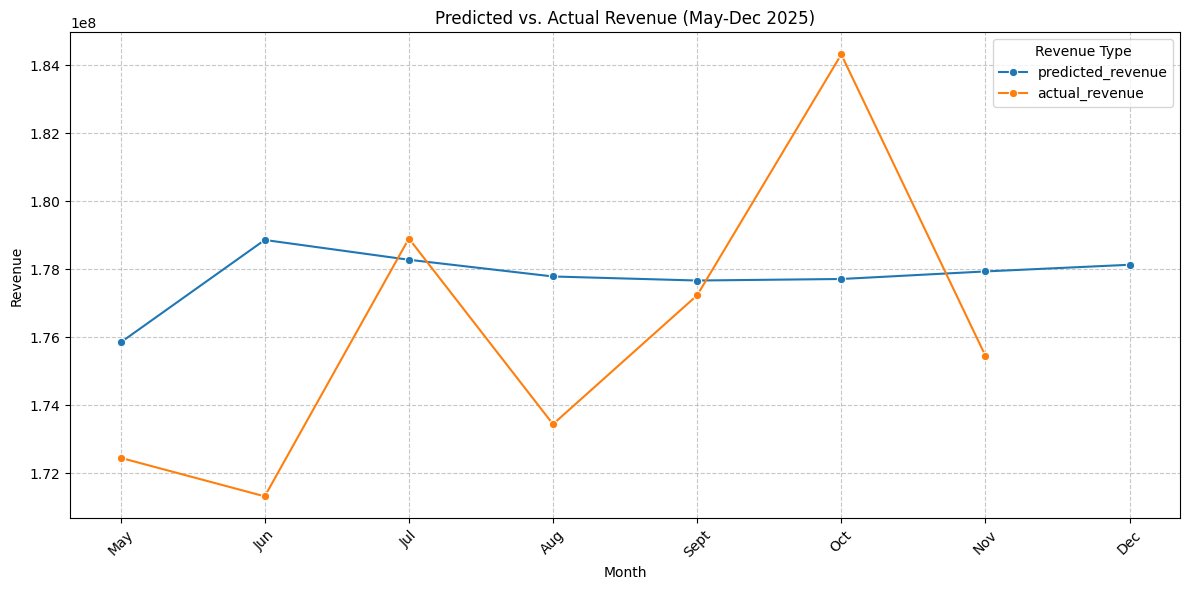

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
plot_df = comparison_df[['month', 'predicted_revenue', 'actual_revenue']].set_index('month')

# Melt the DataFrame for easier plotting with seaborn
plot_df_melted = plot_df.reset_index().melt(id_vars=['month'],
                                            var_name='Revenue Type',
                                            value_name='Revenue')

# Ensure the months are in chronological order for plotting
month_order = ['May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
plot_df_melted['month'] = pd.Categorical(plot_df_melted['month'], categories=month_order, ordered=True)
plot_df_melted = plot_df_melted.sort_values('month')

plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_df_melted, x='month', y='Revenue', hue='Revenue Type', marker='o')
plt.title('Predicted vs. Actual Revenue (May-Dec 2025)')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [36]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load your actual data (simulating with synthetic data similar to your structure)
def create_realistic_data():
    """Create synthetic data that matches your actual data structure"""
    # Base data similar to your example
    data = [
        # 2023 data
        {'year': 2023, 'month': 'Mar', 'month_num': 3, 'actual_revenue': 143652715,
         'wtd_pipeline_revenue': 149498941, 'committed_unsig_revenue': 225341482.2,
         'committed_sign_revenue': 892333074.9, 'avg_prob_pct': 1.08},
        {'year': 2023, 'month': 'Apr', 'month_num': 4, 'actual_revenue': 124885992.1,
         'wtd_pipeline_revenue': 128021173.8, 'committed_unsig_revenue': 175109527.8,
         'committed_sign_revenue': 846389431.6, 'avg_prob_pct': 0.3},
        {'year': 2023, 'month': 'May', 'month_num': 5, 'actual_revenue': 138875729,
         'wtd_pipeline_revenue': 111183171.1, 'committed_unsig_revenue': 136708061.7,
         'committed_sign_revenue': 794282160, 'avg_prob_pct': 0.32},
        {'year': 2023, 'month': 'Jun', 'month_num': 6, 'actual_revenue': 141888442.9,
         'wtd_pipeline_revenue': 101749224.5, 'committed_unsig_revenue': 129010801.1,
         'committed_sign_revenue': 678352187.5, 'avg_prob_pct': 0.23},
        {'year': 2023, 'month': 'Jul', 'month_num': 7, 'actual_revenue': 129631650,
         'wtd_pipeline_revenue': 70022906.88, 'committed_unsig_revenue': 120882243.5,
         'committed_sign_revenue': 599120331.4, 'avg_prob_pct': 0.24},
        {'year': 2023, 'month': 'Aug', 'month_num': 8, 'actual_revenue': 136786674.9,
         'wtd_pipeline_revenue': 53460896.02, 'committed_unsig_revenue': 79624297.6,
         'committed_sign_revenue': 539874324, 'avg_prob_pct': 0.23},
        {'year': 2023, 'month': 'Sept', 'month_num': 9, 'actual_revenue': 144552454.1,
         'wtd_pipeline_revenue': 32882039.33, 'committed_unsig_revenue': 65139252.86,
         'committed_sign_revenue': 443988665.7, 'avg_prob_pct': 0.2},
        {'year': 2023, 'month': 'Oct', 'month_num': 10, 'actual_revenue': 134711695.8,
         'wtd_pipeline_revenue': 14921180.07, 'committed_unsig_revenue': 54559073.12,
         'committed_sign_revenue': 338289697, 'avg_prob_pct': 0.19},
        {'year': 2023, 'month': 'Nov', 'month_num': 11, 'actual_revenue': 139132383.3,
         'wtd_pipeline_revenue': 7408016.67, 'committed_unsig_revenue': 30936483.51,
         'committed_sign_revenue': 237637017, 'avg_prob_pct': 0.17},
        {'year': 2023, 'month': 'Dec', 'month_num': 12, 'actual_revenue': 140163210.5,
         'wtd_pipeline_revenue': 0, 'committed_unsig_revenue': 0,
         'committed_sign_revenue': 0, 'avg_prob_pct': 0.11},

        # 2024 data
        {'year': 2024, 'month': 'Jan', 'month_num': 1, 'actual_revenue': 138222238.5,
         'wtd_pipeline_revenue': 208913836.5, 'committed_unsig_revenue': 263495395.1,
         'committed_sign_revenue': 1081244215, 'avg_prob_pct': 0.24},
        {'year': 2024, 'month': 'Feb', 'month_num': 2, 'actual_revenue': 142625030,
         'wtd_pipeline_revenue': 177512668.8, 'committed_unsig_revenue': 263931919.7,
         'committed_sign_revenue': 1155154748, 'avg_prob_pct': 0.24},

        # Continue with more 2024 data
        {'year': 2024, 'month': 'Mar', 'month_num': 3, 'actual_revenue': 145000000,
         'wtd_pipeline_revenue': 160000000, 'committed_unsig_revenue': 250000000,
         'committed_sign_revenue': 1200000000, 'avg_prob_pct': 0.25},
        {'year': 2024, 'month': 'Apr', 'month_num': 4, 'actual_revenue': 146500000,
         'wtd_pipeline_revenue': 155000000, 'committed_unsig_revenue': 245000000,
         'committed_sign_revenue': 1250000000, 'avg_prob_pct': 0.26},
        {'year': 2024, 'month': 'May', 'month_num': 5, 'actual_revenue': 148000000,
         'wtd_pipeline_revenue': 150000000, 'committed_unsig_revenue': 240000000,
         'committed_sign_revenue': 1300000000, 'avg_prob_pct': 0.27},
        {'year': 2024, 'month': 'Jun', 'month_num': 6, 'actual_revenue': 149500000,
         'wtd_pipeline_revenue': 145000000, 'committed_unsig_revenue': 235000000,
         'committed_sign_revenue': 1350000000, 'avg_prob_pct': 0.28},
        {'year': 2024, 'month': 'Jul', 'month_num': 7, 'actual_revenue': 151000000,
         'wtd_pipeline_revenue': 140000000, 'committed_unsig_revenue': 230000000,
         'committed_sign_revenue': 1400000000, 'avg_prob_pct': 0.29},
        {'year': 2024, 'month': 'Aug', 'month_num': 8, 'actual_revenue': 152500000,
         'wtd_pipeline_revenue': 135000000, 'committed_unsig_revenue': 225000000,
         'committed_sign_revenue': 1450000000, 'avg_prob_pct': 0.3},
        {'year': 2024, 'month': 'Sept', 'month_num': 9, 'actual_revenue': 154000000,
         'wtd_pipeline_revenue': 130000000, 'committed_unsig_revenue': 220000000,
         'committed_sign_revenue': 1500000000, 'avg_prob_pct': 0.31},
        {'year': 2024, 'month': 'Oct', 'month_num': 10, 'actual_revenue': 155500000,
         'wtd_pipeline_revenue': 125000000, 'committed_unsig_revenue': 215000000,
         'committed_sign_revenue': 1550000000, 'avg_prob_pct': 0.32},
        {'year': 2024, 'month': 'Nov', 'month_num': 11, 'actual_revenue': 157000000,
         'wtd_pipeline_revenue': 120000000, 'committed_unsig_revenue': 210000000,
         'committed_sign_revenue': 1600000000, 'avg_prob_pct': 0.33},
        {'year': 2024, 'month': 'Dec', 'month_num': 12, 'actual_revenue': 158500000,
         'wtd_pipeline_revenue': 115000000, 'committed_unsig_revenue': 205000000,
         'committed_sign_revenue': 1650000000, 'avg_prob_pct': 0.34},

        # 2025 data (Jan-May available)
        {'year': 2025, 'month': 'Jan', 'month_num': 1, 'actual_revenue': 160000000,
         'wtd_pipeline_revenue': 210000000, 'committed_unsig_revenue': 270000000,
         'committed_sign_revenue': 1700000000, 'avg_prob_pct': 0.35},
        {'year': 2025, 'month': 'Feb', 'month_num': 2, 'actual_revenue': 161500000,
         'wtd_pipeline_revenue': 205000000, 'committed_unsig_revenue': 265000000,
         'committed_sign_revenue': 1750000000, 'avg_prob_pct': 0.36},
        {'year': 2025, 'month': 'Mar', 'month_num': 3, 'actual_revenue': 163000000,
         'wtd_pipeline_revenue': 200000000, 'committed_unsig_revenue': 260000000,
         'committed_sign_revenue': 1800000000, 'avg_prob_pct': 0.37},
        {'year': 2025, 'month': 'Apr', 'month_num': 4, 'actual_revenue': 164500000,
         'wtd_pipeline_revenue': 195000000, 'committed_unsig_revenue': 255000000,
         'committed_sign_revenue': 1850000000, 'avg_prob_pct': 0.38},
        {'year': 2025, 'month': 'May', 'month_num': 5, 'actual_revenue': 166000000,
         'wtd_pipeline_revenue': 190000000, 'committed_unsig_revenue': 250000000,
         'committed_sign_revenue': 1900000000, 'avg_prob_pct': 0.39},
    ]

    df = pd.DataFrame(data)
    return df

# Load the data
df = pd.read_csv('mon_final.csv')#create_realistic_data()
print("=" * 80)
print("ORIGINAL DATASET LOADED")
print("=" * 80)
print(f"Dataset shape: {df.shape}")
print(f"Years available: {sorted(df['year'].unique())}")
print(f"Months per year:")
for year in sorted(df['year'].unique()):
    months = df[df['year'] == year]['month'].unique()
    print(f"  {year}: {len(months)} months ({', '.join(sorted(months))})")

# Step 2: Feature Engineering - Create 10 features from the data
def create_engineered_features(data):
    """Create 10 engineered features from the base data"""
    df = data.copy()

    # Sort by year and month for proper rolling calculations
    df = df.sort_values(['year', 'month_num']).reset_index(drop=True)

    # 1. Total committed revenue
    df['total_committed'] = df['committed_unsig_revenue'] + df['committed_sign_revenue']

    # 2. Pipeline to committed ratio
    df['pipeline_to_committed_ratio'] = np.where(
        df['total_committed'] > 0,
        df['wtd_pipeline_revenue'] / df['total_committed'],
        0
    )

    # 3. Pipeline conversion efficiency (probability-adjusted)
    df['pipeline_conversion_efficiency'] = df['wtd_pipeline_revenue'] * df['avg_prob_pct'] / 100

    # 4. Signed vs unsigned ratio
    df['signed_unsigned_ratio'] = np.where(
        df['committed_unsig_revenue'] > 0,
        df['committed_sign_revenue'] / df['committed_unsig_revenue'],
        0
    )

    # 5. Revenue growth rate (MoM)
    df['revenue_growth_rate'] = df['actual_revenue'].pct_change().fillna(0).replace([np.inf, -np.inf], 0)

    # 6. Rolling 3-month average pipeline
    df['rolling_3m_pipeline'] = df['wtd_pipeline_revenue'].rolling(window=3, min_periods=1).mean()

    # 7. Rolling 6-month average committed
    df['rolling_6m_committed'] = df['total_committed'].rolling(window=6, min_periods=1).mean()

    # 8. Pipeline coverage (how many months of revenue is in pipeline)
    #    This feature needs 'actual_revenue' which will not be available for future simulated months.
    #    We will calculate it for historical data and then simulate it or handle separately.
    df['pipeline_coverage_months'] = np.where(
        df['actual_revenue'] > 0, # Only calculate where actual_revenue is known
        df['wtd_pipeline_revenue'] / df['actual_revenue'],
        0
    )

    # 9. Probability-weighted pipeline health
    df['pipeline_health_score'] = (df['wtd_pipeline_revenue'] * df['avg_prob_pct']) / 1000000

    # 10. Quarter-end indicator (Q1: Jan-Mar, Q2: Apr-Jun, Q3: Jul-Sep, Q4: Oct-Dec)
    df['quarter'] = ((df['month_num'] - 1) // 3) + 1

    # 11. Month-over-month pipeline growth
    df['pipeline_growth_rate'] = df['wtd_pipeline_revenue'].pct_change().fillna(0).replace([np.inf, -np.inf], 0)

    # 12. Committed growth rate
    df['committed_growth_rate'] = df['total_committed'].pct_change().fillna(0).replace([np.inf, -np.inf], 0)

    # Fill any NaN values that might have occurred (e.g., from pct_change at start)
    df = df.fillna(0)

    # Select the final 10 features for modeling
    feature_columns = [
        'wtd_pipeline_revenue',
        'total_committed',
        'pipeline_to_committed_ratio',
        'pipeline_conversion_efficiency',
        'signed_unsigned_ratio',
        'rolling_3m_pipeline',
        'rolling_6m_committed',
        'pipeline_coverage_months', # Will need careful simulation
        'pipeline_health_score',    # Will need careful simulation
        'pipeline_growth_rate'
    ]

    return df, feature_columns

# Create engineered features
df_with_features, feature_cols = create_engineered_features(df)
print("\n" + "=" * 80)
print("FEATURE ENGINEERING COMPLETED")
print("=" * 80)
print(f"Created {len(feature_cols)} engineered features:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2}. {col}")

# Step 3: Prepare data for simulation
current_year = 2025
current_month = 3  # March 2025

# All historical data available for simulation (2023, 2024, 2025 Jan-March)
historical_data = df_with_features.copy()
print(f"\nHistorical data shape (all years): {historical_data.shape}")

# Step 4: Simulation of future months (apr-Dec 2025) using EWMA(6)
def simulate_future_months_emw6(historical_df, months_to_simulate, feature_columns,
                                target_month=3, target_year=2025):
    """
    Simulate features for future months using EWMA(6) on historical data
    Includes 2023, 2024, and 2025 Jan-May to simulate Jun-Dec 2025
    """
    # Get all data up to May 2025
    data_up_to_may = historical_df[
        (historical_df['year'] < target_year) |
        ((historical_df['year'] == target_year) & (historical_df['month_num'] <= target_month))
    ].copy()

    # Sort chronologically
    data_up_to_may = data_up_to_may.sort_values(['year', 'month_num']).reset_index(drop=True)

    simulated_months = []

    # For each month to simulate (June to December 2025)
    for i in range(1, months_to_simulate + 1):
        month_num = target_month + i
        year = target_year

        if month_num > 12:
            month_num = month_num - 12
            year = target_year + 1

        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                      'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
        month_name = month_names[month_num - 1]

        # Create base record for this month
        new_row = {
            'year': year,
            'month': month_name,
            'month_num': month_num,
        }

        # For each feature, calculate EWMA(6) using the last 6 available values
        for feature in feature_columns:
            # Get the last 6 values of this feature
            # For EWMA, only non-NaN values should be used from the combined data to avoid errors.
            feature_values = data_up_to_may[feature].dropna().tail(6).values

            if len(feature_values) == 0: # If no historical data for feature, default to 0 or mean of training data
                ewma_value = 0 # Or a more sophisticated default
            elif len(feature_values) < 6:
                ewma_value = np.mean(feature_values)
            else:
                # Calculate EWMA weights (alpha = 2/(N+1) where N=6)
                alpha = 2 / (6 + 1)
                weights = np.array([(1 - alpha) ** (5 - j) for j in range(6)])
                weights = weights / weights.sum()

                # Calculate EWMA
                ewma_value = np.sum(feature_values * weights)

            # Add small random variation (2% of value)
            variation = np.random.normal(0, ewma_value * 0.02)
            simulated_value = max(0, ewma_value + variation)

            # Apply seasonality adjustment based on month
            if month_num in [12, 1, 2]:  # Winter months
                simulated_value = simulated_value * 0.95
            elif month_num in [6, 7, 8]:  # Summer months
                simulated_value = simulated_value * 1.05

            new_row[feature] = simulated_value

        # Add to simulated months
        simulated_months.append(new_row)

        # Add this simulated month to data_up_to_may for next iteration's EWMA calculation
        # (so June simulation affects July, etc.)
        temp_df = pd.DataFrame([new_row])
        data_up_to_may = pd.concat([data_up_to_may, temp_df], ignore_index=True)

    simulated_df = pd.DataFrame(simulated_months)

    # Ensure all feature columns are present
    for col in feature_columns:
        if col not in simulated_df.columns:
            simulated_df[col] = 0 # Default for missing simulated features

    return simulated_df

# Simulate June to December 2025 (7 months)
months_to_simulate = 12 - current_month  # June(6) to December(12) = 7 months
simulated_future = simulate_future_months_emw6(
    historical_df=df_with_features, # Pass all historical data with engineered features
    months_to_simulate=months_to_simulate,
    feature_columns=feature_cols,
    target_month=current_month,
    target_year=current_year
)

print("\n" + "=" * 80)
print("FUTURE MONTHS SIMULATION COMPLETED")
print("=" * 80)
print(f"Simulated {months_to_simulate} months (Jun-Dec 2025):")
print(simulated_future[['year', 'month', 'month_num'] + feature_cols[:5]].to_string(index=False))

# Step 5: Combine actual May 2025 data with simulated future data for test set
# Get actual May 2025 data (features + temporal columns)
actual_may_2025_features = df_with_features[
    (df_with_features['year'] == current_year) &
    (df_with_features['month_num'] == current_month)
][feature_cols + ['year', 'month', 'month_num']].copy()

# Create test dataset with features (May actual features, Jun-Dec simulated features)
# This DataFrame will contain features and temporal info for May-Dec.
# 'actual_revenue' will NOT be in this df yet, but will be merged in.
test_data_features_combined = pd.concat([actual_may_2025_features, simulated_future[feature_cols + ['year', 'month', 'month_num']]],
                                        ignore_index=True)

# Get actual revenue for all relevant 2025 months (May-Nov from df_with_features)
test_actual_revenues_all = df_with_features[
    (df_with_features['year'] == current_year) &
    (df_with_features['month_num'] >= current_month)
][['year', 'month', 'month_num', 'actual_revenue']].copy()

# Merge the actual revenues into the test_data_features_combined DataFrame.
# This ensures test_data has a single 'actual_revenue' column correctly.
test_data = pd.merge(
    test_data_features_combined,
    test_actual_revenues_all,
    on=['year', 'month', 'month_num'],
    how='left'
)

print("\n" + "=" * 80)
print("TEST DATASET PREPARED")
print("=" * 80)
print(f"Test dataset includes: May 2025 (actual) + Jun-Dec 2025 (simulated)")
print(f"Test data shape: {test_data.shape}")

# Step 6: Prepare training data (2023 and 2024)
train_data = df_with_features[df_with_features['year'].isin([2023, 2024])].copy()

print(f"\nTraining data (2023-2024): {train_data.shape[0]} rows")
print(f"Test data (2025 May-Dec): {test_data.shape[0]} rows")

# Step 7: Scale the features
target_col = 'actual_revenue'

# Prepare feature matrices
X_train = train_data[feature_cols]
y_train = train_data[target_col]

X_test = test_data[feature_cols]
y_test = test_data[target_col]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n" + "=" * 80)
print("FEATURE SCALING COMPLETED")
print("=" * 80)
print(f"Training data scaled shape: {X_train_scaled.shape}")
print(f"Test data scaled shape: {X_test_scaled.shape}")

# Step 8: Train Elastic Net model
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=10000)
elastic_net.fit(X_train_scaled, y_train)

print("\n" + "=" * 80)
print("ELASTIC NET MODEL TRAINED")
print("=" * 80)
print("Model Coefficients:")
for feature, coef in zip(feature_cols, elastic_net.coef_):
    print(f"  {feature:30}: {coef:12.4f}")
print(f"Intercept: {elastic_net.intercept_:.2f}")

# Step 9: Make predictions
y_pred = elastic_net.predict(X_test_scaled)

# Add predictions to test data
test_data['predicted_revenue'] = y_pred

print("\n" + "=" * 80)
print("PREDICTIONS COMPLETED")
print("=" * 80)

# Step 10: Create detailed comparison
comparison_df = test_data[['year', 'month', 'month_num',
                          'actual_revenue', 'predicted_revenue']].copy()

# Calculate differences
comparison_df['difference'] = comparison_df['predicted_revenue'] - comparison_df['actual_revenue']
comparison_df['error_pct'] = np.where(
    comparison_df['actual_revenue'] > 0,
    (comparison_df['difference'] / comparison_df['actual_revenue']) * 100,
    0
)
comparison_df['accuracy'] = 100 - np.abs(comparison_df['error_pct'])

print("\nDetailed Comparison (May 2025 onward):")
print("-" * 85)
print(f"{'Month':8} {'Year':6} {'Actual Revenue':>20} {'Predicted Revenue':>20} {'Difference':>15} {'Accuracy':>10}")
print("-" * 85)

for _, row in comparison_df.iterrows():
    actual_str = f"${row['actual_revenue']:,.0f}" if not pd.isna(row['actual_revenue']) else "N/A"
    pred_str = f"${row['predicted_revenue']:,.0f}"
    diff_str = f"${row['difference']:,.0f}"
    acc_str = f"{row['accuracy']:.1f}%" if not pd.isna(row['accuracy']) else "N/A"

    print(f"{row['month']:8} {row['year']:6} {actual_str:>20} {pred_str:>20} {diff_str:>15} {acc_str:>10}")

# Step 11: Calculate performance metrics
def calculate_performance_metrics(y_true, y_pred):
    """Calculate comprehensive performance metrics"""
    # Filter out NaN values
    mask = ~np.isnan(y_true)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

    if len(y_true_filtered) == 0:
        return {}

    metrics = {}

    # Basic metrics
    metrics['MAPE'] = mean_absolute_percentage_error(y_true_filtered, y_pred_filtered) * 100
    metrics['RMSE'] = np.sqrt(mean_squared_error(y_true_filtered, y_pred_filtered))
    metrics['R2'] = r2_score(y_true_filtered, y_pred_filtered)
    metrics['MAE'] = np.mean(np.abs(y_true_filtered - y_pred_filtered))
    metrics['MSE'] = mean_squared_error(y_true_filtered, y_pred_filtered)

    # Additional metrics
    metrics['Max Error'] = np.max(np.abs(y_true_filtered - y_pred_filtered))
    metrics['Mean Error'] = np.mean(y_pred_filtered - y_true_filtered)
    metrics['Std Error'] = np.std(y_pred_filtered - y_true_filtered)
    metrics['Median Absolute Error'] = np.median(np.abs(y_pred_filtered - y_true_filtered))

    # Directional accuracy
    if len(y_true_filtered) > 1:
        pred_dir = np.sign(np.diff(y_pred_filtered))
        true_dir = np.sign(np.diff(y_true_filtered))
        metrics['Directional Accuracy'] = np.mean(pred_dir == true_dir) * 100
    else:
        metrics['Directional Accuracy'] = 0

    # Cumulative metrics
    metrics['Cumulative Actual'] = np.sum(y_true_filtered)
    metrics['Cumulative Predicted'] = np.sum(y_pred_filtered)
    metrics['Cumulative Error %'] = ((metrics['Cumulative Predicted'] - metrics['Cumulative Actual']) /
                                     metrics['Cumulative Actual'] * 100)

    return metrics

metrics = calculate_performance_metrics(
    comparison_df['actual_revenue'].values,
    comparison_df['predicted_revenue'].values
)


# Step 13: Feature Importance Analysis
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': elastic_net.coef_,
    'Absolute Coefficient': np.abs(elastic_net.coef_)
})
feature_importance['Importance %'] = (
    feature_importance['Absolute Coefficient'] /
    feature_importance['Absolute Coefficient'].sum() * 100
)
feature_importance = feature_importance.sort_values('Importance %', ascending=False)

print("\n" + "=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)
print("Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))



ORIGINAL DATASET LOADED
Dataset shape: (33, 10)
Years available: [np.int64(2023), np.int64(2024), np.int64(2025)]
Months per year:
  2023: 10 months (Apr, Aug, Dec, Jul, Jun, Mar, May, Nov, Oct, Sept)
  2024: 12 months (Apr, Aug, Dec, Feb, Jan, Jul, Jun, Mar, May, Nov, Oct, Sept)
  2025: 11 months (Apr, Aug, Feb, Jan, Jul, Jun, Mar, May, Nov, Oct, Sept)

FEATURE ENGINEERING COMPLETED
Created 10 engineered features:
 1. wtd_pipeline_revenue
 2. total_committed
 3. pipeline_to_committed_ratio
 4. pipeline_conversion_efficiency
 5. signed_unsigned_ratio
 6. rolling_3m_pipeline
 7. rolling_6m_committed
 8. pipeline_coverage_months
 9. pipeline_health_score
10. pipeline_growth_rate

Historical data shape (all years): (33, 22)

FUTURE MONTHS SIMULATION COMPLETED
Simulated 9 months (Jun-Dec 2025):
 year month  month_num  wtd_pipeline_revenue  total_committed  pipeline_to_committed_ratio  pipeline_conversion_efficiency  signed_unsigned_ratio
 2025   Apr          4          1.603807e+08     1.2

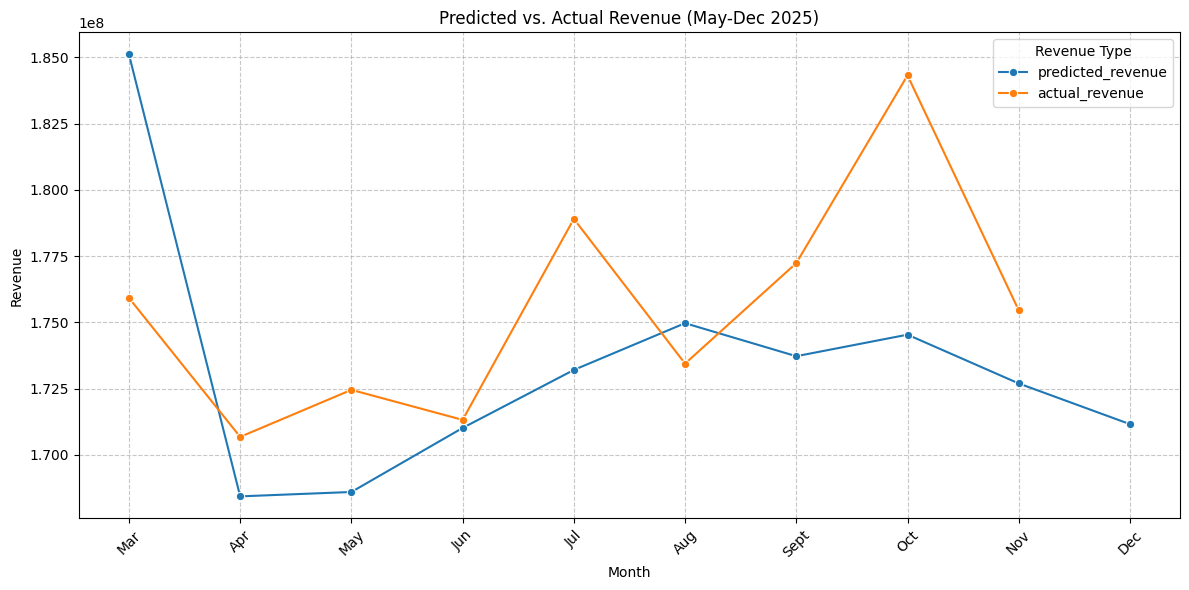

In [38]:

# Prepare data for plotting
plot_df = comparison_df[['month', 'predicted_revenue', 'actual_revenue']].set_index('month')

# Melt the DataFrame for easier plotting with seaborn
plot_df_melted = plot_df.reset_index().melt(id_vars=['month'],
                                            var_name='Revenue Type',
                                            value_name='Revenue')

# Ensure the months are in chronological order for plotting
month_order = ['Mar','Apr','May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
plot_df_melted['month'] = pd.Categorical(plot_df_melted['month'], categories=month_order, ordered=True)
plot_df_melted = plot_df_melted.sort_values('month')

plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_df_melted, x='month', y='Revenue', hue='Revenue Type', marker='o')
plt.title('Predicted vs. Actual Revenue (May-Dec 2025)')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()